In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Path to the images directory
images_path = 'Datasets'  # Adjust this path to your specific setup

# Function to load images from a directory
def load_images_from_folder(folder):
    images = [] # X 
    labels = [] # Y
    file_names = [f for f in os.listdir(folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    for filename in file_names:
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            images.append(img) # X
            labels.append(filename.split('_')[0])  # Assuming filename format is 'label_id.jpg'
    return images, labels

# Function to preprocess images
def preprocess_images(images, size=(224, 224)):
    images_resized = [cv2.resize(img, size) for img in images]
    images_normalized = np.array(images_resized) / 255.0  # Normalize pixel values
    return images_normalized



In [2]:
# Load and preprocess images
from tensorflow.keras.utils import to_categorical
images, labels = load_images_from_folder(images_path)
images_preprocessed = preprocess_images(images)

# Encode labels - simple numerical encoding and convert to one-hot
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)
labels_one_hot = to_categorical(labels_encoded)

In [7]:
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load ResNet50 base model without the top
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Create a new model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(11, activation='softmax')  # Assuming 3 classes for the task
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [4]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.001,
    verbose=1
)

In [5]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configuration
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

X_train, X_test, Y_train, Y_test = train_test_split(images_preprocessed, labels_one_hot, test_size=0.6, random_state=42)

# Prepare to collect scores
fold_no = 1
loss_per_fold = []
accuracy_per_fold = []

for train_idx, val_idx in kfold.split(X_train, Y_train):
    print(f'Training fold {fold_no}...')
    
    # Split data
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = Y_train[train_idx], Y_train[val_idx]

    # Fit the model
    history = model.fit(
        X_train_fold, y_train_fold,
        batch_size=16,
        epochs=20,
        verbose=1,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluate the model
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: Loss = {scores[0]}; Accuracy = {scores[1]*100}%')
    loss_per_fold.append(scores[0])
    accuracy_per_fold.append(scores[1] * 100)

    # Increment the fold number
    fold_no += 1

# Provide average scores
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print(f'Average scores for all folds: Accuracy: {np.mean(accuracy_per_fold):.2f}%, Loss: {np.mean(loss_per_fold):.2f}')
print('------------------------------------------------------------------------')


Training fold 1...
Epoch 1/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 52s 252ms/step - accuracy: 0.8197 - loss: 0.7895 - val_accuracy: 0.9971 - val_loss: 0.0132 - learning_rate: 0.0010
Epoch 2/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 42s 243ms/step - accuracy: 0.9764 - loss: 0.0947 - val_accuracy: 0.9567 - val_loss: 0.1842 - learning_rate: 0.0010
Epoch 3/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 44s 253ms/step - accuracy: 0.9740 - loss: 0.1033 - val_accuracy: 0.9885 - val_loss: 0.0640 - learning_rate: 0.0010
Epoch 4/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 42s 241ms/step - accuracy: 0.9876 - loss: 0.0704 - val_accuracy: 0.9841 - val_loss: 0.0759 - learning_rate: 0.0010
Epoch 5/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 41s 236ms/step - accuracy: 0.9910 - loss: 0.0442 - val_accuracy: 0.9971 - val_loss: 0.0293 - learning_rate: 0.0010
Epoch 6/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.9794 - loss: 0.1124 - val_accuracy: 0.9913 - val_loss: 0.0446 - learning_rate: 0.0010
Epoch 6: early stopping
Restoring model weights fro

In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_train, Y_train)
print(f"Validation accuracy: {test_accuracy}")

109/109 ━━━━━━━━━━━━━━━━━━━━ 44s 398ms/step - accuracy: 0.9998 - loss: 4.4254e-04
Validation accuracy: 0.9991337060928345


In [12]:
def plot_predictions(r=5 ,c =5):
  w=10
  h=10
  fig=plt.figure(figsize=(12, 12))
  columns = c
  rows = r
  for i in range(1, columns*rows +1):
      fig.add_subplot(rows, columns, i)
      rand_n = np.random.randint(X_val_fold.shape[0])
      plt.imshow(X_val_fold[rand_n][:, :, 0], cmap='gray')
      plt.title(f'Actual:{np.argmax(y_val_fold[rand_n])} Predicted: {np.argmax(model.predict(X_val_fold[rand_n].reshape(-1, 224, 224, 3)))}');
      plt.axis('off')
  plt.show()

In [17]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_val_fold, axis=1), np.argmax(model.predict(X_val_fold),axis=1)))

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 302ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        34
           2       1.00      1.00      1.00        70
           3       1.00      1.00      1.00        93
           4       1.00      1.00      1.00        72
           5       1.00      1.00      1.00        88
           6       1.00      1.00      1.00        75
           7       1.00      1.00      1.00        47
           8       1.00      1.00      1.00        64
           9       1.00      1.00      1.00        64
          10       1.00      1.00      1.00        35

    accuracy                           1.00       692
   macro avg       1.00      1.00      1.00       692
weighted avg       1.00      1.00      1.00       692



22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 358ms/step


<Axes: xlabel='Predicted', ylabel='Actual'>

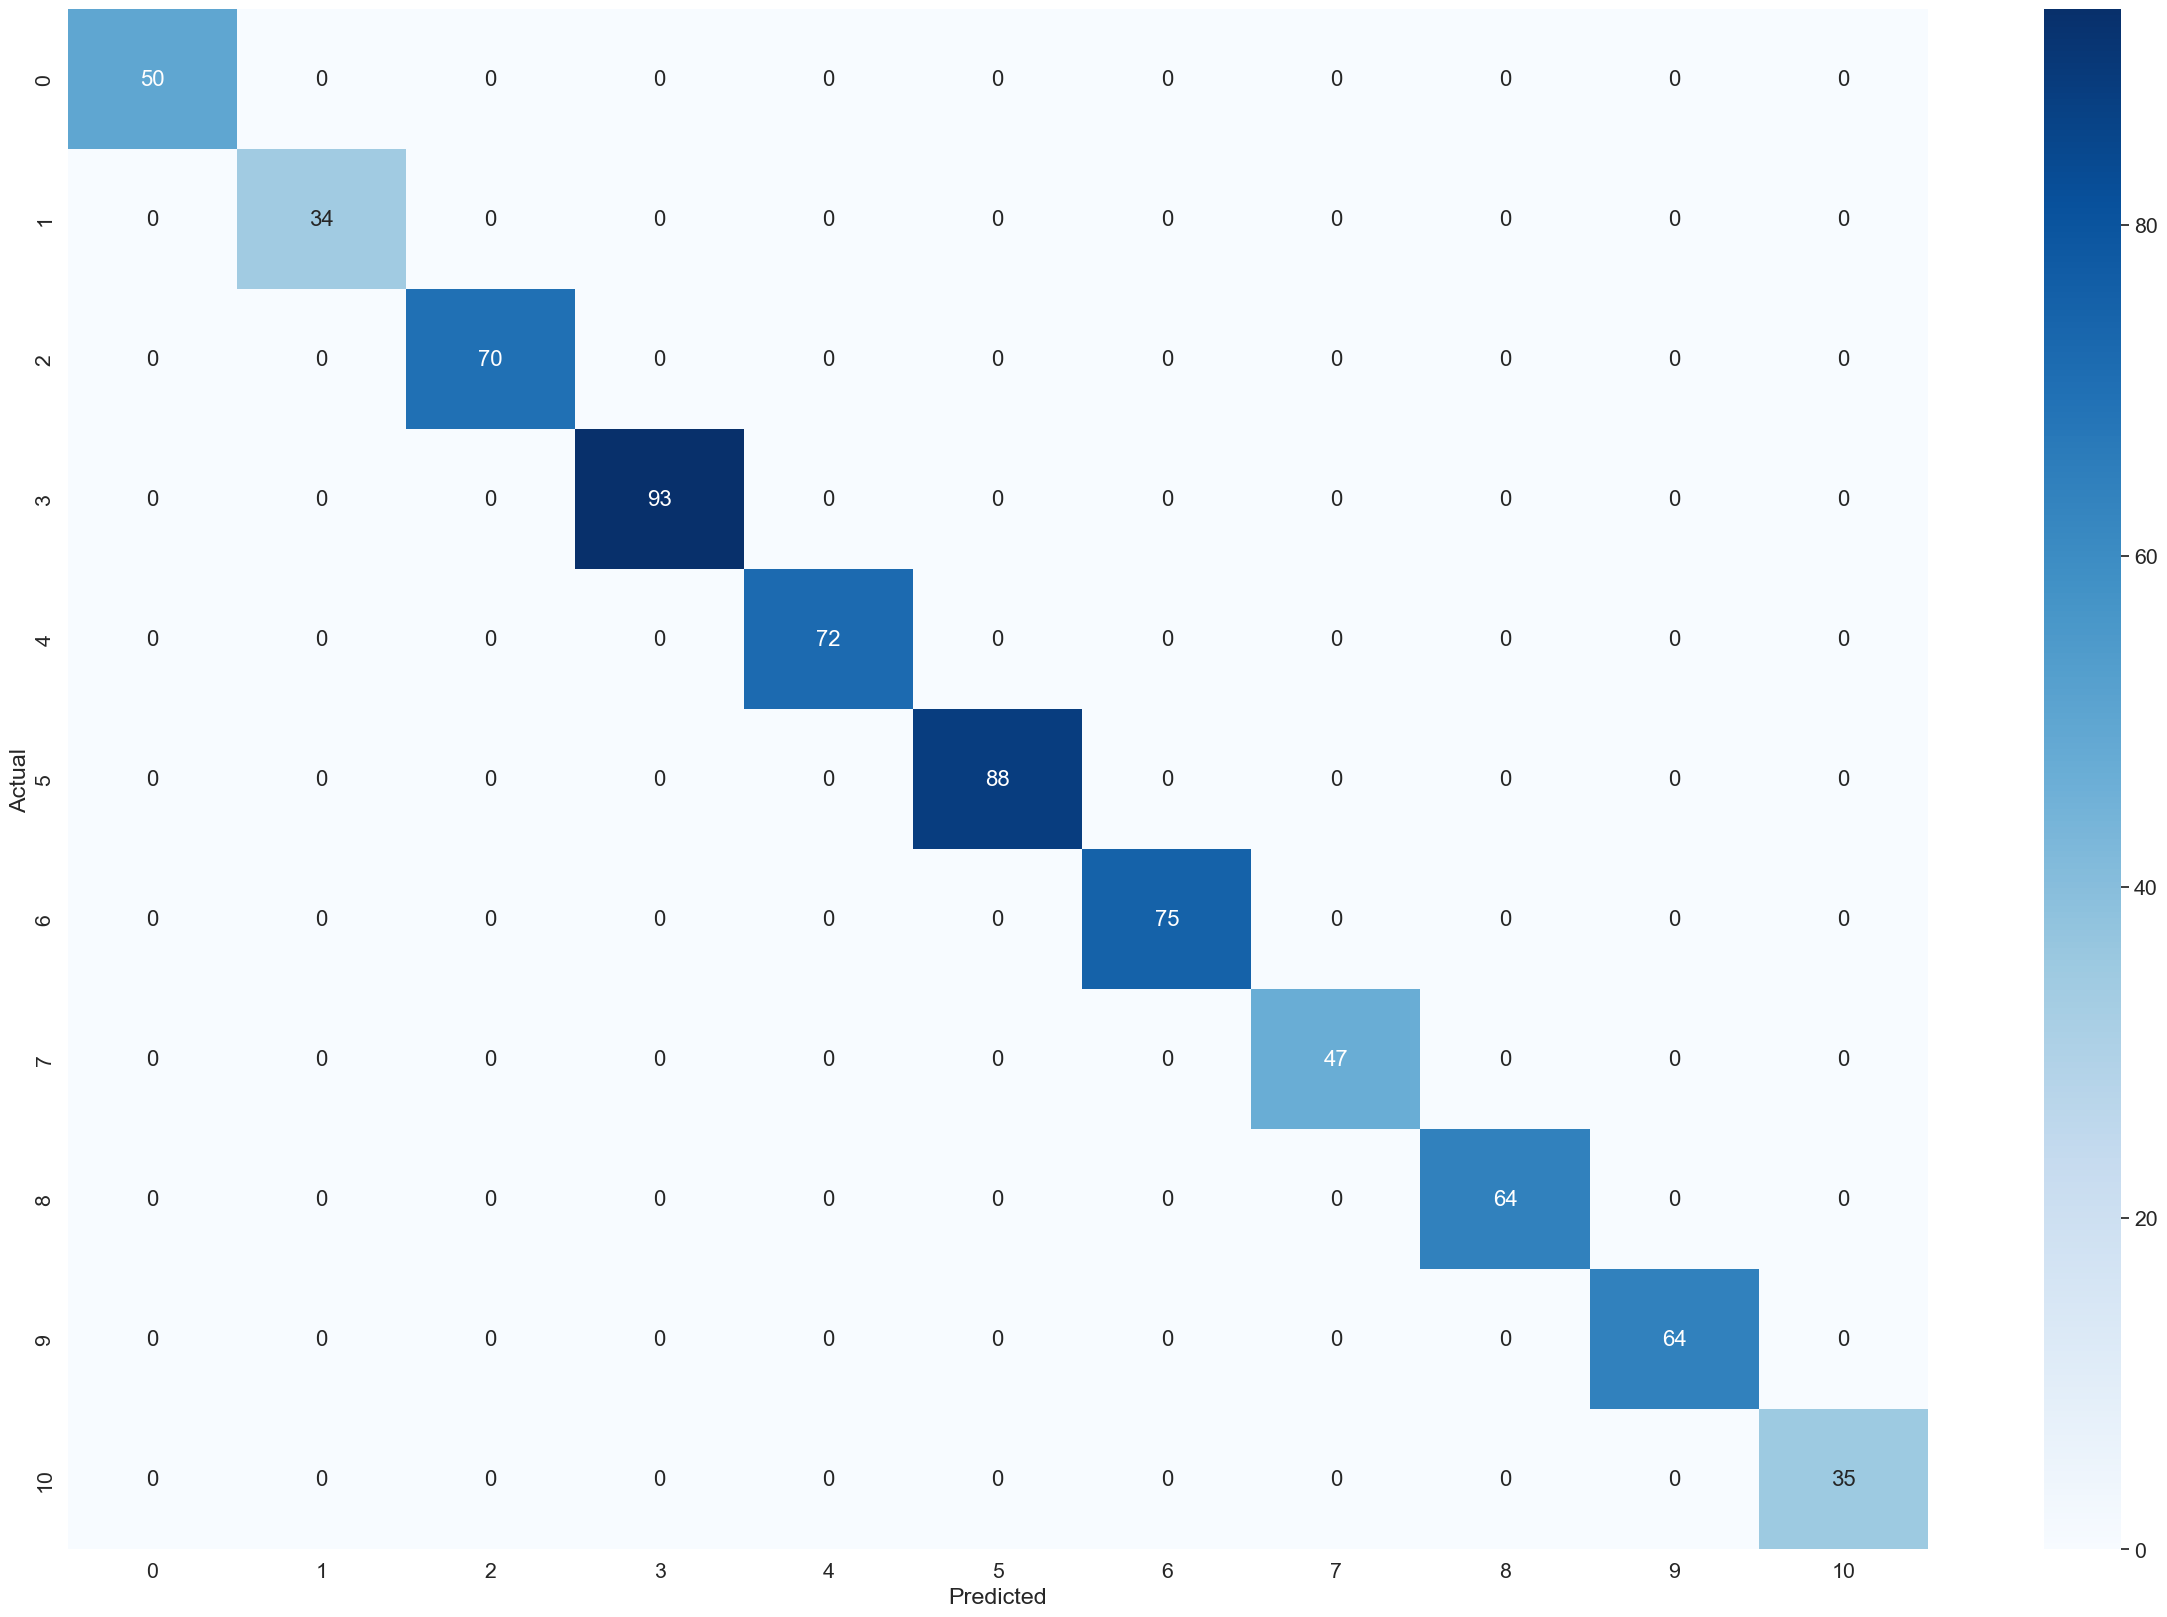

In [9]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score
import seaborn as sn
import pandas as pd
y_true = np.argmax(y_val_fold, axis=1)
y_pred = np.argmax(model.predict(X_val_fold), axis=1)
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (30,20))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


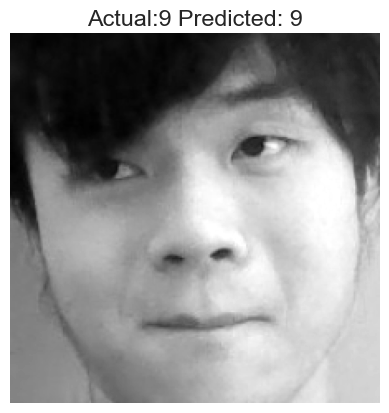

In [12]:
rand_n = np.random.randint(X_val_fold.shape[0])
plt.imshow(X_val_fold[rand_n][:, :, 0], cmap='gray')
plt.title(f'Actual:{np.argmax(y_val_fold[rand_n])} Predicted: {np.argmax(model.predict(X_val_fold[rand_n].reshape(-1, 224, 224, 3)))}');
plt.axis('off')
plt.show()

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(model, X_test, y_test_encoded, r=5, c=5):
    w = 10
    h = 10
    fig = plt.figure(figsize=(20, 20))
    indices = np.random.randint(0, X_test.shape[0], size=r*c)
    predictions = model.predict(X_test[indices])  # Predict in batch for efficiency

    for i in range(1, c*r + 1):
        ax = fig.add_subplot(r, c, i)
        img_index = indices[i-1]
        ax.imshow(X_test[img_index])  # Display the image
        actual_label = np.argmax(y_test_encoded[img_index])
        predicted_label = np.argmax(predictions[i-1])
        ax.set_title(f'Actual:{actual_label} Predicted: {predicted_label}')
        ax.axis('off')
    plt.show()

# Example usage:
# plot_predictions(model, X_test, y_test_encoded, r=5, c=5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


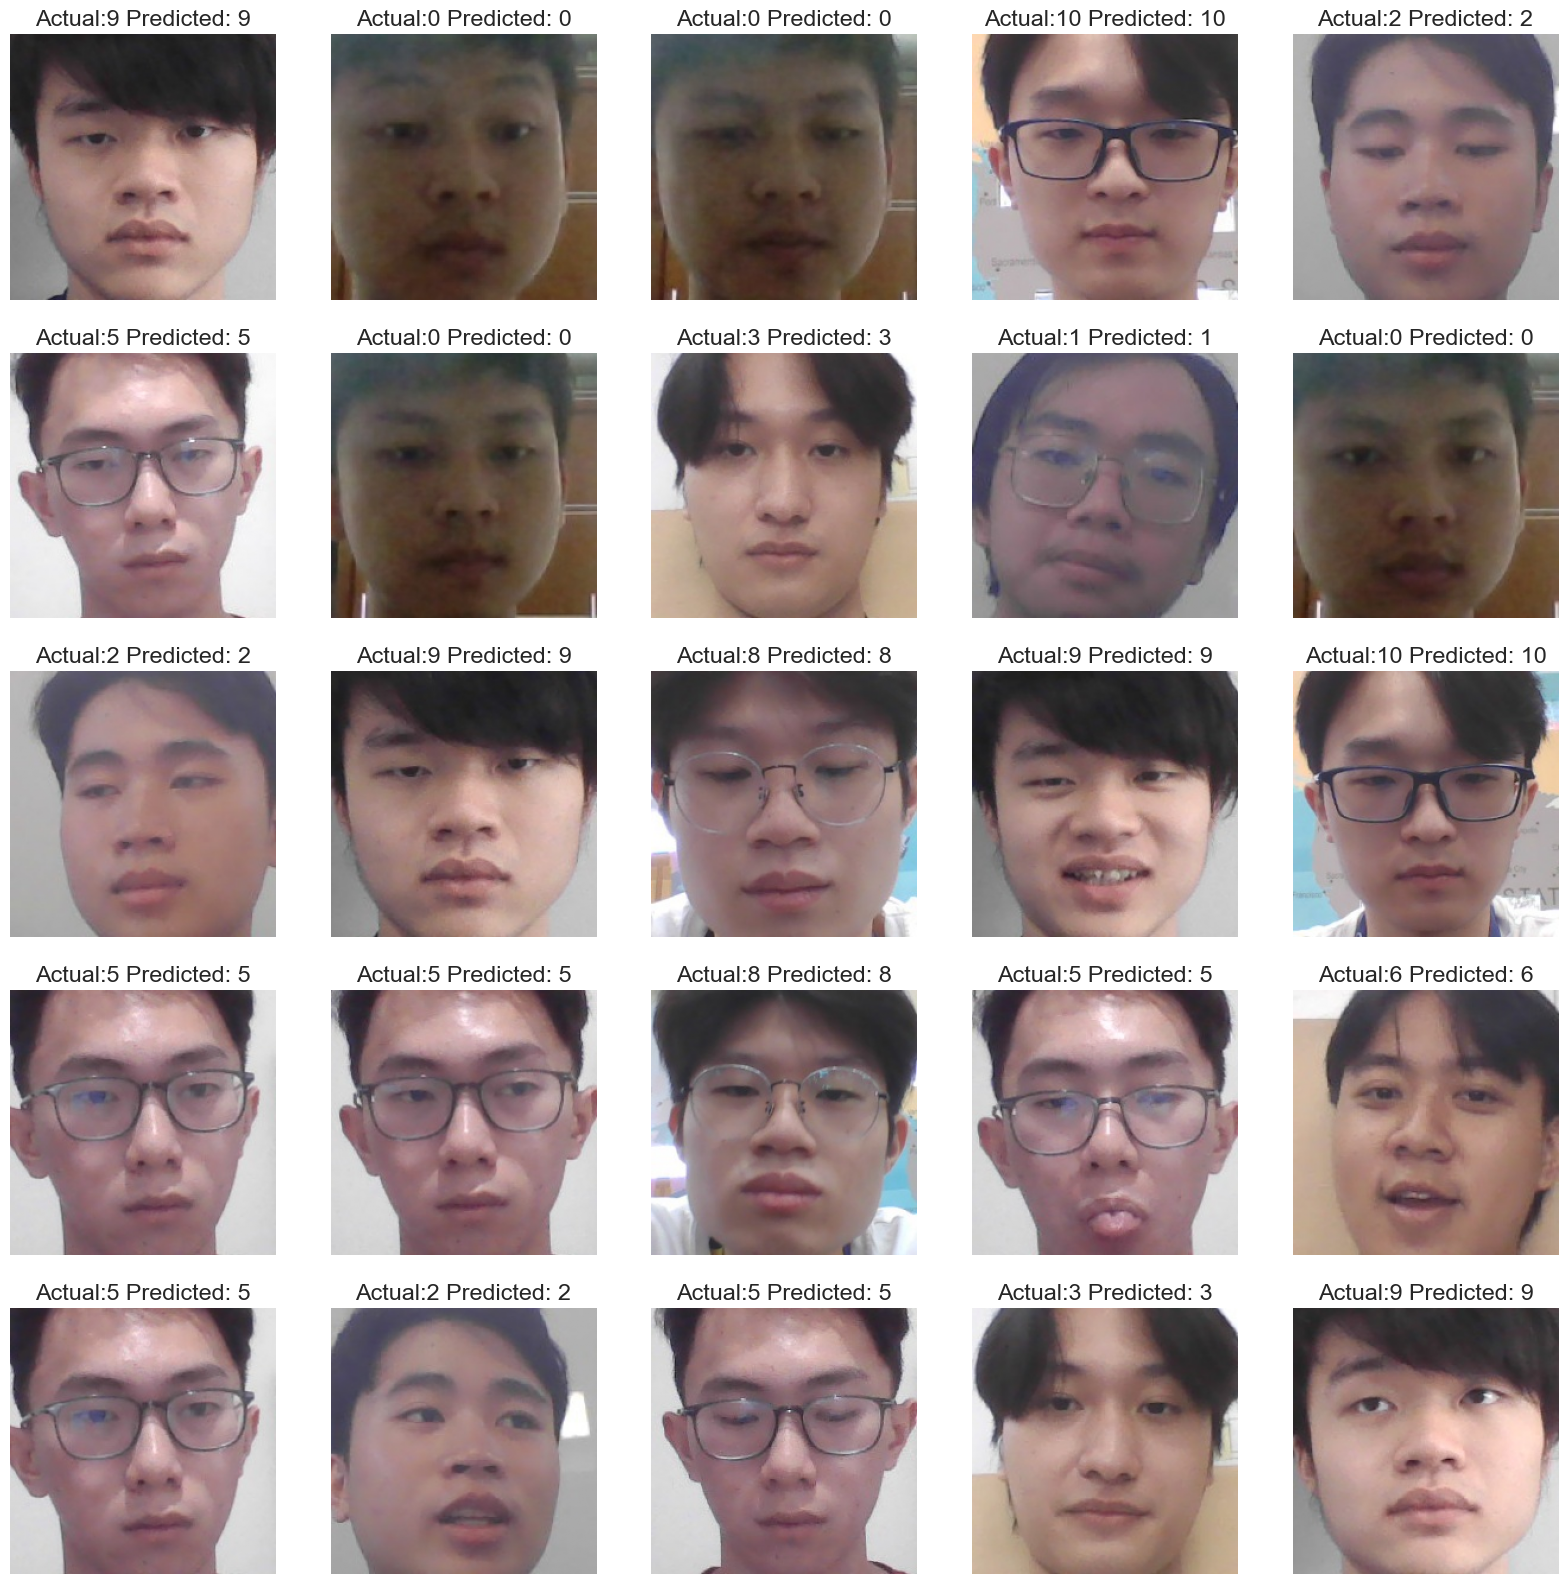

In [ ]:
# Example usage:
plot_predictions(model, X_val_fold, y_val_fold, r=5, c=5)


In [8]:
# Save Model
model.save('Neo_Face_Recognition.keras')

In [3]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your pre-trained model
model = load_model('Neo_Face_Recognition.keras')

# Initialize the webcam
cap = cv2.VideoCapture(0)  # 0 is typically the ID of the built-in webcam

# Define face detection for cropping the face
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Process each detected face
    for (x, y, w, h) in faces:
        # Crop and resize the face to fit the model input
        face = frame[y:y+h, x:x+w]
        face = cv2.resize(face, (224, 224))
        face = np.expand_dims(face, axis=0)  # Expand dims to match the model input shape
        face = face / 255.0  # Normalize the image

        # Predict the face
        prediction = model.predict(face)
        label = np.argmax(prediction, axis=1)  # Assuming you have label encoding

        # Display the bounding box and label
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(frame, f'Label: {label}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    # Display the resulting frame
    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
history = load_model('Neo_Face_Recognition.keras')

# Plot training & test accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & test loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


KeyboardInterrupt



In [1]:
# Loding model from disk
from tensorflow.keras.models import load_model
model = load_model('Neo_Face_Recognition.keras')

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Path to the images directory
images_path = 'Datasets'  # Adjust this path to your specific setup

# Function to load images from a directory
def load_images_from_folder(folder):
    images = [] # X 
    labels = [] # Y
    file_names = [f for f in os.listdir(folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    for filename in file_names:
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            images.append(img) # X
            labels.append(filename.split('_')[0])  # Assuming filename format is 'label_id.jpg'
    return images, labels

# Function to preprocess images
def preprocess_images(images, size=(224, 224)):
    images_resized = [cv2.resize(img, size) for img in images]
    images_normalized = np.array(images_resized) / 255.0  # Normalize pixel values
    return images_normalized



In [3]:
# Load and preprocess images
from tensorflow.keras.utils import to_categorical
images, labels = load_images_from_folder(images_path)
images_preprocessed = preprocess_images(images)

# Encode labels - simple numerical encoding and convert to one-hot
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)
labels_one_hot = to_categorical(labels_encoded)

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(images_preprocessed, labels_one_hot, test_size=0.6, random_state=42)

In [6]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")

163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 416ms/step - accuracy: 0.9930 - loss: 0.1372
Validation accuracy: 0.993840217590332
Validation loss: 0.1102873757481575


In [7]:
# Evaluate the model on the test set
train_loss, train_accuracy = model.evaluate(X_train, Y_train)
print(f"Train accuracy: {train_accuracy}")
print(f"Train loss: {train_loss}")

109/109 ━━━━━━━━━━━━━━━━━━━━ 52s 432ms/step - accuracy: 0.9998 - loss: 4.4254e-04
Test accuracy: 0.9991337060928345
Test loss: 0.0032508554868400097


In [10]:
import numpy as np
from sklearn.model_selection import KFold, train_test_split

# Configuration
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

for train_idx, val_idx in kfold.split(X_train, Y_train):
    # print(f'Training fold {fold_no}...')
    
    # Split data
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = Y_train[train_idx], Y_train[val_idx]